Show adding selective recurrent inhibition improves the performance of a Voja memory with when neuron noise is injected.

In [13]:
import string

import nengo
from nengo import processes
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nengo_learn_assoc_mem.utils import BasicVecFeed

# Train basic Voja memory

In [2]:
seed = 8
D = 16
n_neurons = 100
n_items = 16
intercepts = np.ones(n_neurons) * 0.3

In [3]:
vocab = spa.Vocabulary(D, max_similarity=0.3)
vocab.populate(";".join([string.ascii_uppercase[i] for i in range(n_items)]))

In [4]:
vecs = vocab.vectors
simi = np.dot(vecs, vecs.T)
np.fill_diagonal(simi, 0)
max_simi = np.max(simi)
max_simi

0.2960045795869784

In [5]:
len(vecs)

16

In [6]:
t_present = 0.3
t_pause = 0.0
n_repeats = 5
t_each = t_present+t_pause

voja_learn_rate = 1e-5
pes_learn_rate = 1e-3

In [7]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: -feed.paused)
    correct = nengo.Node(feed.get_answer)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, intercepts=intercepts, neuron_type=nengo.LIF())

    in_conn = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(voja_learn_rate), synapse=None)
    nengo.Connection(learning, in_conn.learning_rule, synapse=None)
    conn_out = nengo.Connection(ens, output, learning_rule_type=nengo.PES(1e-3))

    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] > 0 else x[:-1] * 0,
        size_in=D + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.05)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:11.                                                                              


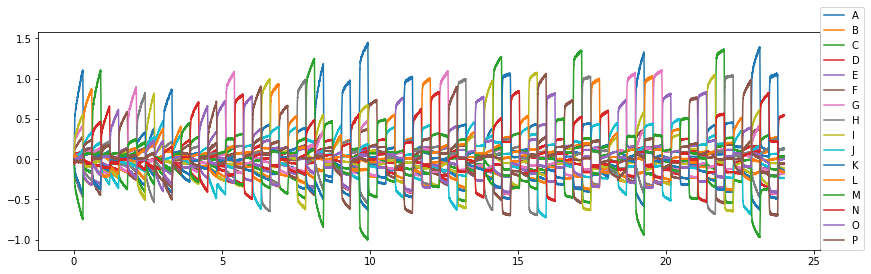

In [8]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

In [9]:
enc = sim.data[p_enc][-1]
dec = sim.data[p_dec][-1]

In [10]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:02.                                                                              


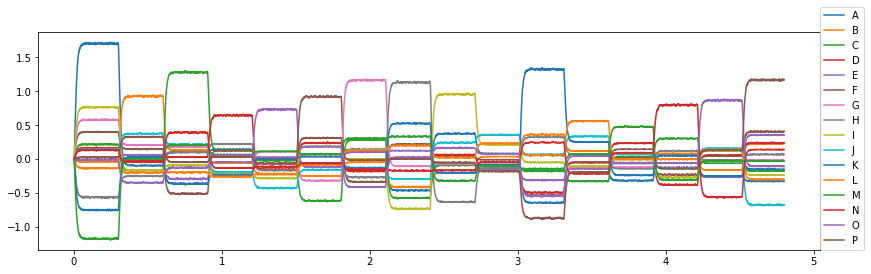

In [11]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

# Response to High Frequency noise

In [66]:
vecs = [vocab.parse(letter).v for letter in ("J", "D", "J", "D")]

In [89]:
feed = BasicVecFeed(vecs, vecs, t_present, D, len(vecs), t_pause)
noise_proc = processes.WhiteNoise(
    dist=nengo.dists.Gaussian(0, 0.4), seed=1)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, noise=noise_proc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:01.                                                                              


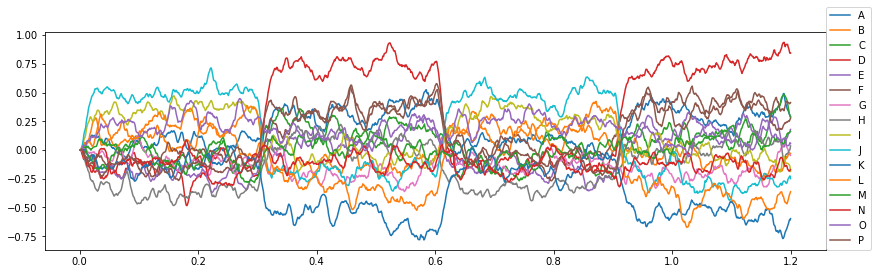

In [90]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

# Enhance with Analytical Rec BCM

For each input, get the rates of each neuron.

Outer-product and threshold.

In [91]:
base_inhib_mag = -2e-3

In [92]:
vecs = vocab.vectors

In [93]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, intercepts=intercepts)

with nengo.Simulator(model) as sim:
    pass

Building finished in 0:00:01.                                                                                


In [94]:
_, activities = tuning_curves(ens, sim, inputs=vecs)

In [95]:
act_corr = np.zeros((n_neurons, n_neurons), dtype=np.float)

for item in range(n_items):
    act_corr += np.outer(activities[item], activities[item])

In [96]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 1] = 0
np.fill_diagonal(rec_w, 0)

In [97]:
vecs = [vocab.parse(letter).v for letter in ("J", "D", "J", "D")]

In [98]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, noise=noise_proc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_w)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:01.                                                                              


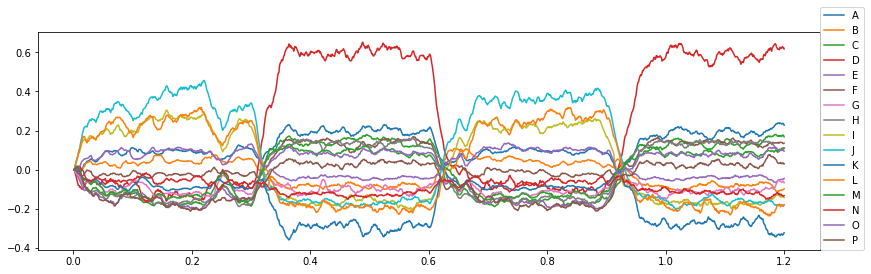

In [99]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

In [100]:
mean_act = np.mean(activities, axis=0)

In [101]:
max_corr = np.max(act_corr)
min_corr = np.min(act_corr)

In [102]:
rec_w = np.ones((n_neurons, n_neurons), dtype=np.float) * base_inhib_mag
rec_w[act_corr > 0.] = (1 - act_corr[act_corr > 0.] / max_corr) * -4e-5
rec_w[act_corr < 0.] = act_corr[act_corr < 0.] / min_corr * -6e-1
np.fill_diagonal(rec_w, 0)

In [103]:
vecs = [vocab.parse(letter).v for letter in ("J", "D", "J", "D")]

In [104]:
feed = BasicVecFeed(list(vecs), list(vecs), t_present, D, len(vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    output = nengo.Node(size_in=D)
    
    ens = nengo.Ensemble(n_neurons, D, encoders=enc, noise=noise_proc, intercepts=intercepts)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_w)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:01.                                                                              


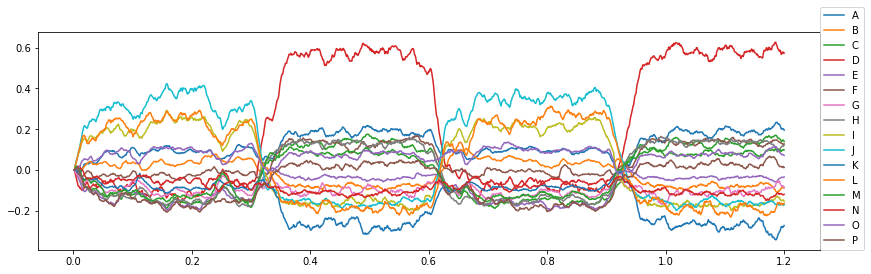

In [105]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_out], vocab))
plt.legend(vocab.keys(), loc=(1, 0));

Very slight improvement when responding to neural noise. But hardly any difference between basic analytic setting of the weights and subtlely grading the weights on correlation, which is a good thing for biological plausibility.